#---목표---#
1. 형태소 단위의 토큰화 (komoran / wordpiece) 비교하기 
    * 형태소로 하는 이유 : 안다, 안한다, 안에 (동사, 부사, 명사 구분) 
2. oov의 경우, 가까운 음운으로 변환해주는 코드 개발 
    * 100개 (최대) corpus 설정 후 그 안에서 hyter parameter 설정에 따라 비슷한 단어를 같은 인덱스로 묶는 경우 
    * 100개 (최대) corpus 설정 후 임베딩 과정에서 oov가 발생할 경우, 가장 비슷한 단어를 같은 인덱스로 붙여주는 경우 (임베딩 time complexity가 굉장히 늘어남) 
3. 임베딩: padding, 형태소, 문장, 단어 
4. 위와 같이 새로운 임베딩 방식을 기반으로 한 kobert pre-training & fine-tuning
5. train 할때는 masked sentence까지 포함한다. 
6. nsmc + 국립국어원 웹 corpus 데이터 이용 
    '모두의 말뭉치'에서 웹 말뭉치, 형태 분석 말뭉치를 사용한다.  
7. 웹말뭉치 + nsmc train 으로 단어 사전 생성 및 pre-train 해보기 


nsmc_EDA
#---전처리 과정---#
1. 특수문자, 이모티콘, 숫자, 공백 (일단 숫자와 공백만 제거하기) 
2. 토큰화 (패키지에 따라 형태소 구분 방식이 다르기 때문에 앙상블을 이용해보자..) 
3. 불용어, 표제어 제거 (한국어에서는 불용어를 따로 지정하는 것이 좋음. 품사에 따라 지정해보자!) 

#---시각화 과정---#
1. 클래스 개수 비율 분포 v
2. 한 문장 당 사용 단어 수 v
3. 전체 데이터 내에서 단어 빈도수 v
4. 토큰화 후 임베딩 시 UNK 토큰의 수 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import os
import logging
import argparse
import random
from tqdm import tqdm, trange
import pandas as pd

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
#from transformers import BertAdam
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

from transformers import PYTORCH_PRETRAINED_BERT_CACHE

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        sample 하나 당 하나의 InputExample. 다음과 같은 argument가 전달 됨.  
            guid: 하나의 example에 대한 고유 번호.
            text_a: 토큰화 하기 전 첫번째 문장
            text_b: 토큰화 하기 전 두번째 문장
            label: (문자열) example의 라벨. 
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [3]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
        
    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_txt(cls, input_file, quotechar=None):
        """Reads a tab separated value file.
            파일에서 한 줄 씩 읽어 lines 리스트에 저장합니다. 
        """
        with open(input_file, "r", encoding='utf-8') as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                #print(line)
                lines.append(line)
            return lines

In [4]:
"""nsmc 데이터를 처리하는 nsmcProcessor"""

class nsmcProcessor(DataProcessor):
    """Processor for the nsmc data set (Naver sentiment movie corpus v1.0)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "ratings_train.txt")))
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_train.txt")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_dev.txt")), "dev")
    
    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_test.txt")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"] # 부정 0 긍정 1

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets.
           각 줄에서 guid, text_a, text_b, label을 추출하여 InputExample을 통해 데이터 재정렬.    
        """
        examples = []
        for (i, line) in enumerate(lines):
            if i==0: 
                continue
            guid = "%s-%s" % (set_type, i) #train/dev + index 
            text_a = line[1]
            text_b = None
            label = int(line[2])
            #print("text_a: ", text_a, "label:", label)
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

In [5]:
"""모두의 말뭉치 웹 말뭉치 데이터를 처리하는 webmProcessor"""

class webmProcessor(DataProcessor):
    """Processor for the "web malmoongchi" data set"""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "ratings_train.txt")))
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_train.txt")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_dev.txt")), "dev")
    
    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_txt(os.path.join(data_dir, "ratings_test.txt")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"] # 부정 0 긍정 1

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets.
           각 줄에서 guid, text_a, text_b, label을 추출하여 InputExample을 통해 데이터 재정렬.    
        """
        examples = []
        for (i, line) in enumerate(lines):
            if i==0: 
                continue
            guid = "%s-%s" % (set_type, i) #train/dev + index 
            text_a = line[1]
            text_b = None
            label = int(line[2])
            #print("text_a: ", text_a, "label:", label)
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

In [6]:
data_dir = "../data/"

# 데이터 불러오기 위한 개체 생성 
processor = nsmcProcessor()
# train data 불러오기 
train_examples = processor.get_train_examples(data_dir)

print("{:2} ".format("label\ttext"))
for (ex_index, example) in enumerate(train_examples):
    if ex_index < 5:
        print("{:6} ".format(example.label), end=' ')
        print("{:<100} ".format(example.text_a))

09/04/2020 20:08:21 - INFO - __main__ -   LOOKING AT ../data/ratings_train.txt


label	text 
     0  아 더빙.. 진짜 짜증나네요 목소리                                                                                  
     1  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나                                                                    
     0  너무재밓었다그래서보는것을추천한다                                                                                    
     0  교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정                                                                        
     1  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다                                        


In [7]:
#클래스 개수 비율 분포 
def countLabel(data):
    count0 = 0
    count1 = 0
    for (ex_index, example) in enumerate(data):
        if example.label == 0: 
            count0+=1
        elif example.label == 1: 
            count1+=1
    total = len(data)
    print("총 데이터 개수:", total)
    print("class 0 개수: %d, 비율: %.2f"%(count0, count0/total))
    print("class 1 개수: %d, 비율: %.2f"%(count1, count1/total))
countLabel(train_examples)

총 데이터 개수: 150000
class 0 개수: 75173, 비율: 0.50
class 1 개수: 74827, 비율: 0.50


In [14]:
#대략적인 vocab size 정하기 
from keras.preprocessing.text import Tokenizer

#단어 빈도수 
def show_word_counts(t, data):
    t.fit_on_texts(data)
    count=t.word_counts
    print(len(count))

    sorted_count=sorted(count.items(), key=lambda item: item[1], reverse=True)
    word_data=pd.DataFrame(sorted_count)
    word_data= word_data.rename(columns={0: "key", 1:"value"})
    
    print(word_data)
    return word_data

#단어 빈도수 분포 
def show_counts_frequency(word_data):
    length=len(word_data)
    list1=[] #count. 단어의 빈도수 list
    list2=[] #frequency. 단어의 빈도수의 빈도수 list
    index=0
    for i in range(length): 
        cnt=0 #단어의 빈도수의 빈도수 
        while length-index-1>=0 and i+1==word_data['value'][length-index-1]:
            cnt+=1
            #print(y2_l-index-1,y2[y2_l-index-1],cnt)
            index+=1
        if(cnt!=0):
            list1.append(i+1)
            list2.append(cnt) 
            
    word_count = pd.DataFrame(list(zip(list1, list2)), 
                   columns =['count', 'frequency']) 
    print(word_count[:100])

    total=0
    for i in range(100):
        total+=word_count['frequency'][i]
    print("1번~100번 등장한 단어의 총 빈도수:", total,
          "전체 단어 대비 1번~100번 등장한 단어(비율):",'{:.2f}'.format(total/length*100))

In [15]:
X=[]
for (ex_index, example) in enumerate(train_examples):
    X.append(example.text_a)

t= Tokenizer(lower=True, oov_token=True)

word_data = show_word_counts(t, X)
show_counts_frequency(word_data)

296310
           key  value
0           영화  18995
1           너무   8563
2           정말   8537
3           진짜   6682
4            이   5418
...        ...    ...
296305     더블은      1
296306    뭔죄인가      1
296307  거들먹거리고      1
296308     혼혈은      1
296309    수간하는      1

[296310 rows x 2 columns]
    count  frequency
0       1     224179
1       2      28976
2       3      11675
3       4       6536
4       5       4279
..    ...        ...
95     96         12
96     97         14
97     98         15
98     99          9
99    100          7

[100 rows x 2 columns]
1번~100번 등장한 단어의 총 빈도수: 295073 전체 단어 대비 1번~100번 등장한 단어(비율): 99.58


In [18]:
import nltk
import matplotlib.pyplot as plt
from keras.preprocessing.text import text_to_word_sequence

def show_token_count(data):
    data_=[]
    for line in data:
        line2=text_to_word_sequence(line) 
        data_.append(line2)
        
    len_result = [len(s) for s in data_]

    plt.clf() #clear previous figure
    plt.hist(len_result,bins=100)
    plt.title('Distribution of length')
    plt.xlabel('length')
    plt.ylabel('number')
    plt.savefig('words_distrib.png', bbox_inches='tight')
    plt.show()

    print('example의 최대 사용 단어 수 : {}'.format(np.max(len_result)))
    print('example의 평균 사용 단어 수 : {:.2f}'.format(np.mean(len_result)))
    print('example의 중앙값 사용 단어 수: {:.2f}'.format(np.median(len_result)))

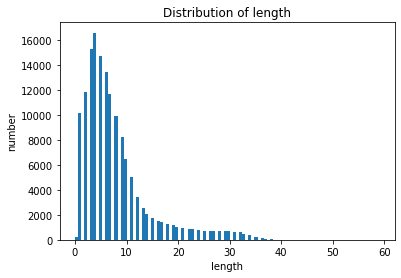

example의 최대 사용 단어 수 : 59
example의 평균 사용 단어 수 : 7.85
example의 중앙값 사용 단어 수: 6.00


In [19]:
show_token_count(X)

In [10]:
#토큰화 (komoran / sentencepiece) 비교
#komoran
import konlpy
from konlpy.tag import Komoran 
komoran = Komoran()

# komoran은 빈줄이 있으면 에러가 남
#komoran.morphs("\n".join([s for s in c[:40].split("\n") if s]))

#21세기 세종계획의 품사기준을 따르고 있다. 
print('세계환경수도 조성위해 10개년 실천계획 만들겠다')
print(komoran.morphs(u'세계환경수도 조성위해 10개년 실천계획 만들겠다'))
print(komoran.pos(u'세계환경수도 조성위해 10개년 실천계획 만들겠다'))
print()
print('아버지가방에들어가신다')
print(komoran.morphs(u'아버지가방에들어가신다'))
print(komoran.pos(u'아버지가방에들어가신다'))
print()
print('걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다')
print(komoran.morphs(u'걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다'))
print(komoran.pos(u'걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다'))

세계환경수도 조성위해 10개년 실천계획 만들겠다
['세계', '환경', '수도', '조성', '위하', '아', '10', '개년', '실천', '계획', '만들', '겠', '다']
[('세계', 'NNG'), ('환경', 'NNP'), ('수도', 'NNP'), ('조성', 'NNG'), ('위하', 'VV'), ('아', 'EC'), ('10', 'SN'), ('개년', 'NNB'), ('실천', 'NNG'), ('계획', 'NNG'), ('만들', 'VV'), ('겠', 'EP'), ('다', 'EC')]

아버지가방에들어가신다
['아버지', '가방', '에', '들어가', '시', 'ㄴ다']
[('아버지', 'NNG'), ('가방', 'NNP'), ('에', 'JKB'), ('들어가', 'VV'), ('시', 'EP'), ('ㄴ다', 'EC')]

걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다
['걍', '너무', '너무', '싶퍼요퓨ㅠㅠ', '민검사님.걍', '쩌', 'ㄹ', '고요', '아', '.', '.', '말', '고안', '나오', 'ㅂ니다']
[('걍', 'NA'), ('너무', 'MAG'), ('너무', 'MAG'), ('싶퍼요퓨ㅠㅠ', 'NA'), ('민검사님.걍', 'NA'), ('쩌', 'EF'), ('ㄹ', 'ETM'), ('고요', 'NNP'), ('아', 'IC'), ('.', 'SF'), ('.', 'SF'), ('말', 'NNG'), ('고안', 'NNP'), ('나오', 'VV'), ('ㅂ니다', 'EC')]


In [29]:
print([('걍', 'NA'), ('너무', 'MAG'), ('너무', 'MAG'), ('싶', 'NA'), ('푸', 'VV'), ('어', 'EC'), ('요퓨ᅲᅲ', 'NA'), ('민', 'NNP'), ('검사', 'NNG'), ('님', 'XSN'), ('.', 'SF'), ('걍', 'NA'), ('쩌', 'EF'), ('ㄹ', 'ETM'), ('고', 'NNP'), ('요', 'MM'), ('아', 'IC'), ('..', 'SE'), ('말', 'VX'), ('고', 'EC'), ('안', 'MAG'), ('나오', 'VV'), ('ㅂ니다', 'EC')])

[('걍', 'NA'), ('너무', 'MAG'), ('너무', 'MAG'), ('싶', 'NA'), ('푸', 'VV'), ('어', 'EC'), ('요퓨ᅲᅲ', 'NA'), ('민', 'NNP'), ('검사', 'NNG'), ('님', 'XSN'), ('.', 'SF'), ('걍', 'NA'), ('쩌', 'EF'), ('ㄹ', 'ETM'), ('고', 'NNP'), ('요', 'MM'), ('아', 'IC'), ('..', 'SE'), ('말', 'VX'), ('고', 'EC'), ('안', 'MAG'), ('나오', 'VV'), ('ㅂ니다', 'EC')]


In [11]:
#sentencepiece
import sentencepiece as spm

# #nsmc txt 파일 생성하기 
# with open('../data/nsmc.txt', 'a') as f:
#     for s in X:
#         f.write("%s\n" % s)

spm.SentencePieceTrainer.train('--input=../data/ratings_train.txt --model_prefix=nsmc_m --vocab_size=144652')
sp = spm.SentencePieceProcessor()
sp.load('nsmc_m.model')

True

In [27]:
import re
from django.contrib.admin.utils import flatten

def convert_pos(pieces):
    komoran = Komoran()
    output=[]
    for p in pieces:
        p = re.sub('▁','',p)
        pos = komoran.pos(p)
        output.append(pos)
    return flatten(output)

In [28]:
#Komoran을 한번 거치는 과정에서 sentencepiece으로 토큰화된 토큰이 더 세부적으로 쪼개지게 됨
#그러면서 품사 태깅을 더 정확하게 하는 효과가 있음!
#정돈된 문장은 komoran, 비문은 sentencepiece가 더 강한 느낌이다. 

print('세계환경수도 조성위해 10개년 실천계획 만들겠다')
print(sp.encode_as_pieces('세계환경수도 조성위해 10개년 실천계획 만들겠다'))
print(convert_pos(sp.encode_as_pieces('세계환경수도 조성위해 10개년 실천계획 만들겠다')))

print()
print('아버지가방에들어가신다')
print(sp.encode_as_pieces('아버지가방에들어가신다'))
print(convert_pos(sp.encode_as_pieces('아버지가방에들어가신다')))

print()
print('걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다')
print(sp.encode_as_pieces('걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다'))
print(convert_pos(sp.encode_as_pieces('걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다')))


세계환경수도 조성위해 10개년 실천계획 만들겠다
['▁세계', '환경', '수도', '▁조성', '위해', '▁10', '개', '년', '▁실천', '계', '획', '▁만들겠다']
[('세계', 'NNG'), ('환경', 'NNG'), ('수', 'NNB'), ('도', 'JX'), ('조성', 'NNG'), ('위하', 'VV'), ('아', 'EC'), ('10', 'SN'), ('개', 'NNB'), ('년', 'NNB'), ('실천', 'NNG'), ('계', 'NNG'), ('획', 'MAG'), ('만들', 'VV'), ('겠', 'EP'), ('다', 'EC')]

아버지가방에들어가신다
['▁아버지가', '방에', '들어가', '신다']
[('아버지', 'NNG'), ('가', 'JKS'), ('방', 'NNG'), ('에', 'JKB'), ('들어가', 'VV'), ('아', 'EC'), ('신', 'VV'), ('다', 'EC')]

걍 너무 너무 싶퍼요퓨ㅠㅠ 민검사님.걍 쩔고요 아.. 말고안나옵니다
['▁걍', '▁너무', '▁너무', '▁싶', '퍼', '요퓨ᅲᅲ', '▁민검사님', '.', '걍', '▁쩔고', '요', '▁아', '..', '▁말고', '안나옵니다']
[('걍', 'NA'), ('너무', 'MAG'), ('너무', 'MAG'), ('싶', 'NA'), ('푸', 'VV'), ('어', 'EC'), ('요퓨ᅲᅲ', 'NA'), ('민', 'NNP'), ('검사', 'NNG'), ('님', 'XSN'), ('.', 'SF'), ('걍', 'NA'), ('쩌', 'EF'), ('ㄹ', 'ETM'), ('고', 'NNP'), ('요', 'MM'), ('아', 'IC'), ('..', 'SE'), ('말', 'VX'), ('고', 'EC'), ('안', 'MAG'), ('나오', 'VV'), ('ㅂ니다', 'EC')]
